# Classifiers

```{note}
Please only use the following versions:
`python`: 3.8.16
`pacmap`: 0.7.0
`lightgbm`: 3.3.5
`scikit-learn`: 1.2.2
```

## Where the data at

In [1]:
import pandas as pd

mount = '/mnt/e/ALMA/'
input_path = mount + 'Intermediate_Files/'
output_path = mount + 'Processed_Files/'

## Load data

In [2]:
# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'3314samples_331557cpgs_withbatchcorrection_bvalues.pkl').sort_index().iloc[:,1:]

df_validation = pd.read_pickle(
    input_path+'201samples_427375cpgs_withbatchcorrection_bvalues.pkl').sort_index()[df_discovery.columns]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_validation) contains {df_validation.shape[1]} \
columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

 Discovery dataset (df_discovery) contains 331557 columns (5mC nucleotides/probes) and 3314 rows (samples).
 Validation dataset (df_validation) contains 331557 columns (5mC nucleotides/probes) and 201 rows (samples).


## Reduce dimensionality with PaCMAP

### Set hyperparameters, fit, and save

In [141]:
import pacmap
print('PaCMAP version:', pacmap.__version__)

components_list = [5]
for components in components_list:
    
    reducer = pacmap.PaCMAP(n_components=components, 
                            n_neighbors=10, 
                            MN_ratio=0.4, 
                            FP_ratio=20.0, 
                            lr=0.1, 
                            num_iters=2500,
                            random_state=42,
                            save_tree=True)

    # Project the high dimensional dataset into a low-dimensional embedding
    embedding_training = reducer.fit_transform(df_discovery.to_numpy(dtype='float16'))

    # Save reducer
    pacmap.save(reducer, output_path + f'pacmap/pacmap_{components}d_model_alma')

    # Create column names
    cols = ['PaCMAP '+ str(i+1) + f' of {components}' for i in range(components)]

    # Turn embedding into dataframe
    df_embedding = pd.DataFrame(embedding_training, columns=cols, index=df_discovery.index).to_pickle(
        output_path+f'pacmap/pacmap_{components}d_embedding.pkl')


PaCMAP version: 0.7.0


KeyboardInterrupt: 

### Apply models to new data

In [135]:

def apply_pacmap_model_to_new_data(df, components):

    # Load reducer
    reducer = pacmap.load(output_path + f'pacmap/pacmap_{components}d_model_alma')

    # Project the high dimensional dataset into existing embedding space and return the embedding.
    embedding = reducer.transform(df.to_numpy(dtype='float16'))

    # Create column names
    cols = ['PaCMAP '+ str(i+1) + f' of {components}' for i in range(components)]

    # Turn embedding into dataframe
    df_embedding = pd.DataFrame(embedding, columns=cols, index=df.index)

    return df_embedding


# Apply pacmap model to discovery dataset
train_2d = pd.read_pickle(output_path+'pacmap/pacmap_2d_embedding.pkl')
train_5d = pd.read_pickle(output_path+'pacmap/pacmap_5d_embedding.pkl')

# # Apply pacmap model to validation dataset
test_2d = apply_pacmap_model_to_new_data(df_validation, components=2)
test_5d = apply_pacmap_model_to_new_data(df_validation, components=5)

### Merge results with clinical data

In [136]:
# Join 2d and 5d
train = train_2d.join(train_5d)
test = test_2d.join(test_5d)

# Concatenate train and test
train_test = pd.concat([train, test])

# Read clinical data
clinical_data = pd.read_excel(input_path+'clinical_data.xlsx', index_col=0)

# Join train_test with clinical data
df = train_test.join(clinical_data)

## Preprocess data for classifiers

### Select samples for prognostic model

Here we select samples that have both `vital status` and `time to death` information available publicly. No ALL or MPAL samples are included in this analysis.

In [137]:
# Drop the samples with missing labels for the selected column
df_px = df[~df['Vital Status at 5y'].isna()]

# Select only the samples from the following clinical trials
df_px2 = df_px[df_px['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1', 'AML02', 'AML08'])]

# Select only diagnostic samples
df_px2 = df_px2[df_px2['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow', 'Primary Blood Derived Cancer - Peripheral Blood'])]

# Remove duplicates
df_px2 = df_px2[~df_px2['Patient_ID'].duplicated(keep='last')]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df_px2.shape[0], 'samples removed.'\
, df_px2.shape[0], 'samples remaining.')

df_px2['Train-Test'].value_counts()

2369 samples removed. 1146 samples remaining.


Train-Test
Train Sample    946
Test Sample     200
Name: count, dtype: int64

### Select samples Dx

Here we select samples that have `WHO 2022 Diagnosis` information available publicly. See chapter on clinical data processing for how programatic reclassification to WHO 2022 was performed.

We also exclude `AML with t(9;22); BCR::ABL1` subtype category due to having fewer than 5 samples representing it (n=3).

In [138]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_dx = df[~df['WHO 2022 Diagnosis'].isna()]

# exclude the classes with fewer than 10 samples
df_dx2 = df_dx[~df_dx['WHO 2022 Diagnosis'].isin(['AML with t(9;22); BCR::ABL1'])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df_dx2.shape[0], 'samples removed.'\
, df_dx2.shape[0], 'samples remaining.')

df_dx2['Train-Test'].value_counts()

946 samples removed. 2569 samples remaining.


Train-Test
Train Sample    2467
Test Sample      102
Name: count, dtype: int64

### Define X and y

In [139]:
def custom_train_test_split(df, feature_columns, target_column, split_column):

    X = df[feature_columns].to_numpy(dtype='float16')
    y = df[target_column].to_numpy()

    train_mask = df[split_column] == 'Train Sample'
    test_mask = df[split_column] == 'Test Sample'

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

    return X_train, X_test, y_train, y_test

# Execution
X_train_dx, X_test_dx, y_train_dx, y_test_dx = custom_train_test_split(df_dx2, test_5d.columns,'WHO 2022 Diagnosis', 'Train-Test')
X_train_px, X_test_px, y_train_px, y_test_px = custom_train_test_split(df_px2, test_5d.columns,'Vital Status at 5y', 'Train-Test')


X_train shape: (2467, 5) X_test shape: (102, 5)
X_train shape: (946, 5) X_test shape: (200, 5)


## Benchmark classifiers

Best parameters: {'class_weight': 'balanced', 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Overall accuracy score in Train with 10-fold CV: 0.989
Overall accuracy score in Validation: 0.922


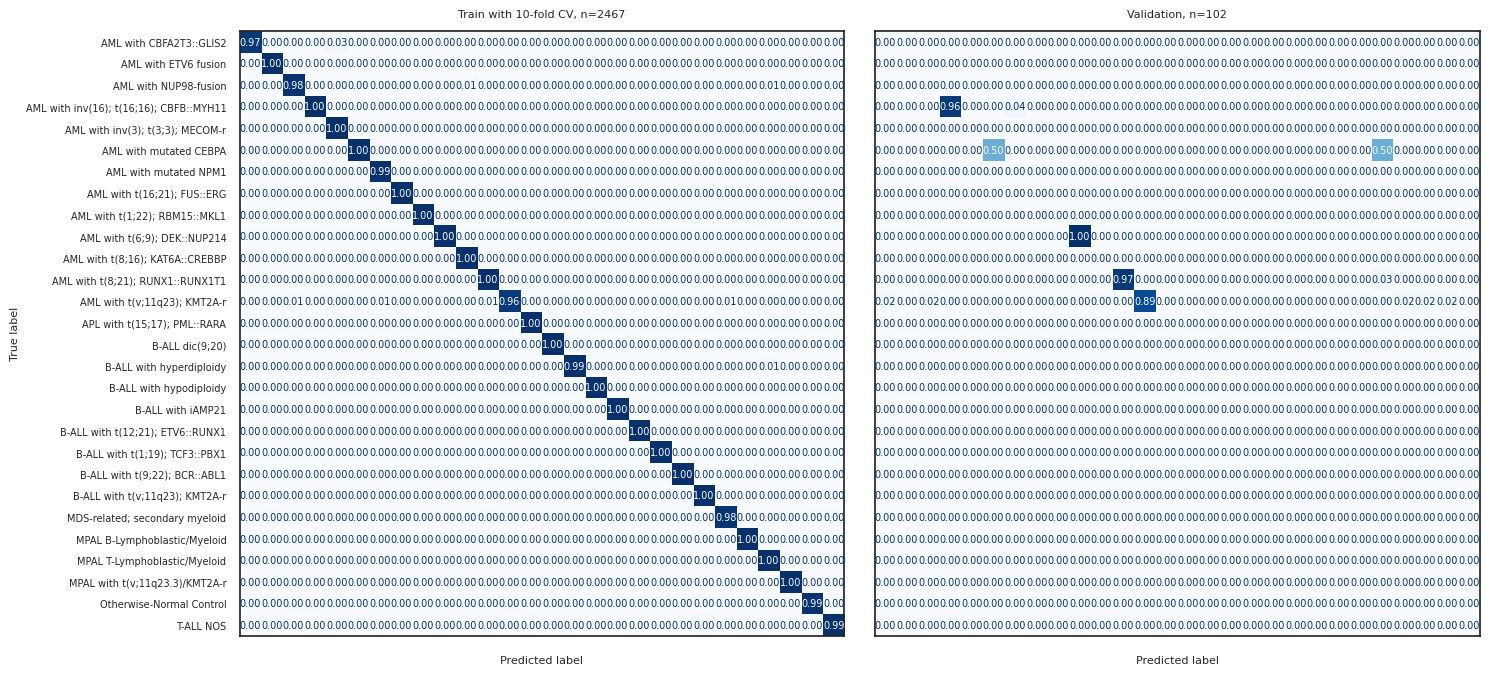

Best parameters: {'class_weight': 'balanced', 'reg_alpha': 10, 'reg_lambda': 1}
Overall accuracy score in Train with 10-fold CV: 0.670
Overall accuracy score in Validation: 0.665


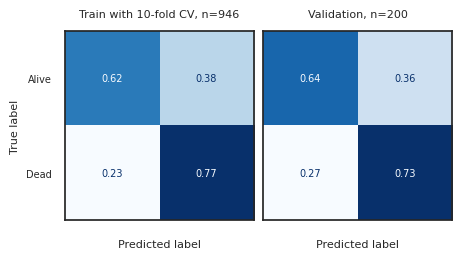

['/mnt/e/ALMA/Processed_Files/lgbm/lgbm_dx_model.pkl']

In [140]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import joblib
import sys
sys.path.append('../')
from source.data_visualization import plot_confusion_matrix_stacked


def benchmark_classifier(X_train, y_train, X_test, y_test, figsize=(16,8)):

    param_grid = {
    # 'num_leaves': [ 5, 6, 7, 8, 9, 10], # number of leaves in full tree
    # 'max_depth': [3,4,5,6,7,8,9,10],  # maximum depth of a tree
    # 'learning_rate': [0.01],  # shrinkage rate
    # 'n_estimators': [50, 100, 500],  # number of trees (or rounds)
    'reg_alpha': [0.1, 1, 10],  # L1 regularization
    'reg_lambda': [0.1, 1],  # L2 regularization
    'class_weight': ['balanced'],  # weights associated with classes    
    }

    # Initialize the LGBM Classifier with regularization
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1) 
                          
    # Perform grid search with stratified cross-validation
    grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1,
                               scoring='roc_auc_ovr_weighted')

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")

    # Get the best model
    clf = grid_search.best_estimator_

    plot = plot_confusion_matrix_stacked(clf, X_train, y_train, X_test, y_test,
                                  tick_fontsize=7, label_fontsize=7, figsize=figsize)
    return clf, plot

    # Plot the confusion matrix

# Benchmark, train
lgbm_dx_model, plot = benchmark_classifier(X_train_dx, y_train_dx, X_test_dx, y_test_dx)
lgbm_px_model, plot = benchmark_classifier(X_train_px, y_train_px, X_test_px, y_test_px, figsize=(5,3))

# Save models
joblib.dump(lgbm_px_model, output_path + 'lgbm/lgbm_px_model.pkl')
joblib.dump(lgbm_dx_model, output_path + 'lgbm/lgbm_dx_model.pkl')

## Save results

In [10]:
df['Clinical Trial'].value_counts(dropna=False)

Clinical Trial
NOPHO ALL92-2000            933
AAML0531                    628
AAML1031                    587
Beat AML Consortium         316
TCGA AML                    194
CETLAM SMD-09 (MDS-tAML)    166
AML02                       159
French GRAALL 2003–2005     141
TARGET ALL                  131
AAML03P1                     72
Japanese AML05               64
AML08                        42
CCG2961                      41
BM normal AAML0531           41
Name: count, dtype: int64

In [11]:
# Import dependencies again in case only this cell is run
import numpy as np
import pandas as pd
import joblib

# Load models
lgbm_px_model = joblib.load(output_path + 'lgbm/lgbm_px_model.pkl')
lgbm_dx_model = joblib.load(output_path + 'lgbm/lgbm_dx_model.pkl')

def save_predictions(df, classifier, model_name):

    # ignore sklearn warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Select necessary columns
    df_features = df[test_5d.columns]

    # Predict using the selected columns
    predictions = classifier.predict(df_features)

    # Predict probabilities using the selected columns
    probabilities = classifier.predict_proba(df_features)

    # Convert predictions to a Series with the same index as df_features
    predictions_series = pd.Series(predictions, index=df_features.index, name=model_name)

    # Convert probabilities to a DataFrame with the same index as df_features and the same columns as the classes
    probabilities_df = pd.DataFrame(probabilities, index=df_features.index, columns=classifier.classes_).round(3)

    # Add " - predict_proba" to the column names
    probabilities_df.columns ='P(' + probabilities_df.columns + ')'

    # Transform classes of the predictions into integers based on unique values in the classes
    probabilities_df[model_name + '_int'] = predictions_series.map({c: i for i, c in enumerate(classifier.classes_)})

    # Join predictions with the original DataFrame (already indexed)
    df_joined = predictions_series.to_frame().join(probabilities_df)

    return df_joined

# Execution
df_pred_px = save_predictions(df=df, classifier=lgbm_px_model, model_name='AML Epigenomic Risk')
df_pred_dx = save_predictions(df=df, classifier=lgbm_dx_model, model_name='AL Epigenomic Subtype')

# Map the classes to more desirable labels (low and high risk)
df_pred_px['AML Epigenomic Risk'] = df_pred_px['AML Epigenomic Risk'].map({'Alive': 'Low', 'Dead': 'High'})
df_pred_px = df_pred_px.rename(columns={'P(Alive)': 'P(Remission) at 5y', 'P(Dead)': 'P(Death) at 5y'})

# Select ALL samples
lymphoblastic_leukemia_samples = df[df['Clinical Trial'].isin(['NOPHO ALL92-2000', 'French GRAALL 2003–2005', 'TARGET ALL'])].index

# Remove ALL samples from df_pred_px since they should not be part of the AML Epigenomic Risk
df_pred_px = df_pred_px.drop(lymphoblastic_leukemia_samples)

# Join predictions with clinical data
df_combined = df.join(df_pred_px).join(df_pred_dx)

# Save df_combined
df_combined.to_excel('../data/alma_main_results.xlsx')

# Print saved path
print('Dataset saved to ../data/alma_main_results.xlsx')

Dataset saved to ../data/alma_main_results.xlsx


## Watermark

In [12]:
%load_ext watermark

In [13]:
# watermark with all libraries used in this notebook
%watermark -v -p numpy,pandas,pacmap,sklearn,lightgbm -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

numpy   : 1.24.3
pandas  : 2.0.2
pacmap  : 0.7.0
sklearn : 1.2.2
lightgbm: 3.3.5

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit



```{note}
Updating to python 3.10 caused substantial delays in lightgbm, so please use the following versions:
`python`: 3.8.16
`pacmap`: 0.7.0
`lightgbm`: 3.3.5
`scikit-learn`: 1.2.2
```